In [15]:
import pandas as pd

#for pandas_datareader, otherwise it might have issues
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import mplfinance as mpf
import yfinance as yahoo_finance
yahoo_finance.pdr_override()

In [16]:
#variable

ticker = 'USA'
start_time = datetime.datetime(2017, 10, 1)

#end_time = datetime.datetime(2019, 1, 20)

end_time = datetime.datetime.now().date().isoformat()   # today

In [17]:
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass
    


ticker_df = ticker_df.reset_index()
print(ticker_df)


[*********************100%***********************]  1 of 1 completed
connected to yahoo
          Date  Open  High   Low  Close  Adj Close   Volume
0   2017-10-02  6.03  6.08  6.02   6.05   4.096505  1180000
1   2017-10-03  6.07  6.08  6.02   6.02   4.076193  1467700
2   2017-10-04  6.04  6.09  6.02   6.07   4.110049  1251300
3   2017-10-05  6.09  6.15  6.06   6.14   4.157445  1606700
4   2017-10-06  6.13  6.16  6.08   6.08   4.116819   790200
..         ...   ...   ...   ...    ...        ...      ...
909 2021-05-13  7.63  7.91  7.63   7.89   7.890000  1153200
910 2021-05-14  8.04  8.11  8.00   8.10   8.100000   874900
911 2021-05-17  8.05  8.14  8.02   8.12   8.120000   502900
912 2021-05-18  8.12  8.20  8.10   8.16   8.160000   634800
913 2021-05-19  8.03  8.14  7.99   8.14   8.140000   672600

[914 rows x 7 columns]


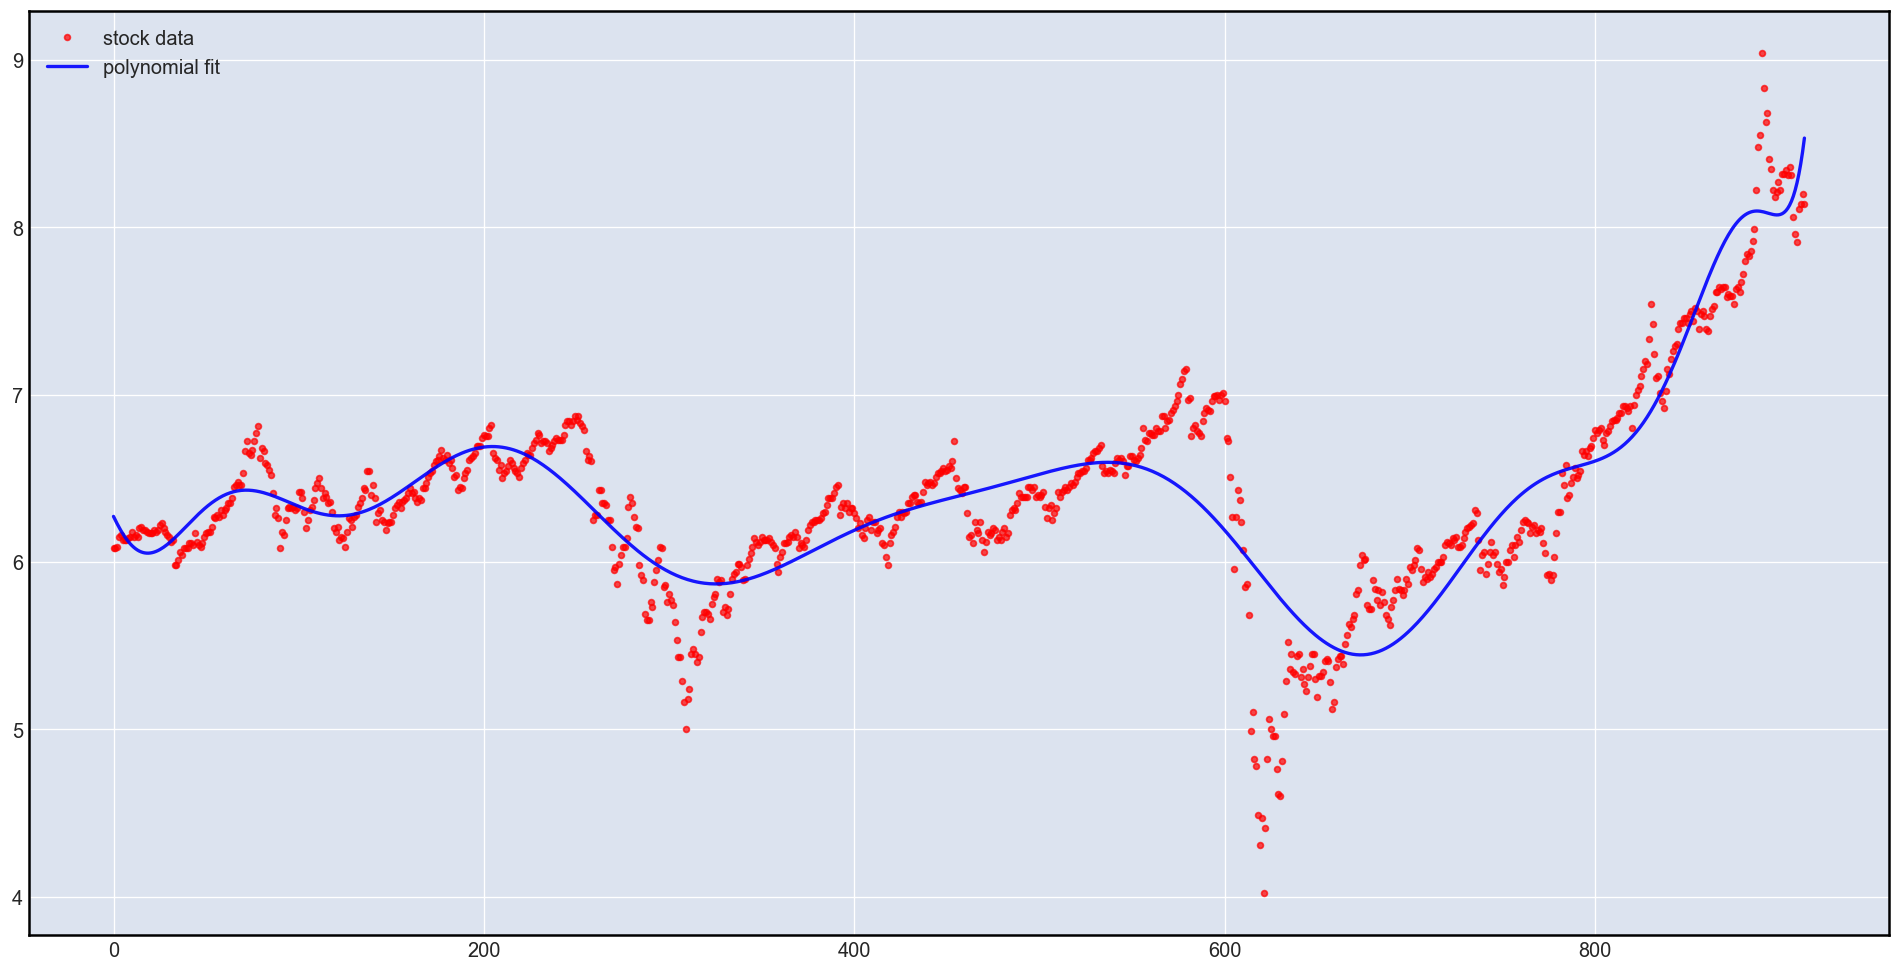

In [18]:
# discrete dataset
x_data = ticker_df.index.tolist()      
y_data = ticker_df['High']

# x values for the polynomial fit, 200 points
x = np.linspace(0, max(ticker_df.index.tolist()), max(ticker_df.index.tolist()) + 1)

# polynomial fit of degree xxx
pol = np.polyfit(x_data, y_data, 15)
y_pol = np.polyval(pol, x)

# ___ plotting ___
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
# plot stock data
plt.plot(x_data, y_data, 'o', markersize=3.5, color='red', alpha=0.7)
# plot polynomial fit
plt.plot(x, y_pol, '-', markersize=1.0, color='blue', alpha=0.9)
plt.legend(['stock data', 'polynomial fit'])
plt.show()


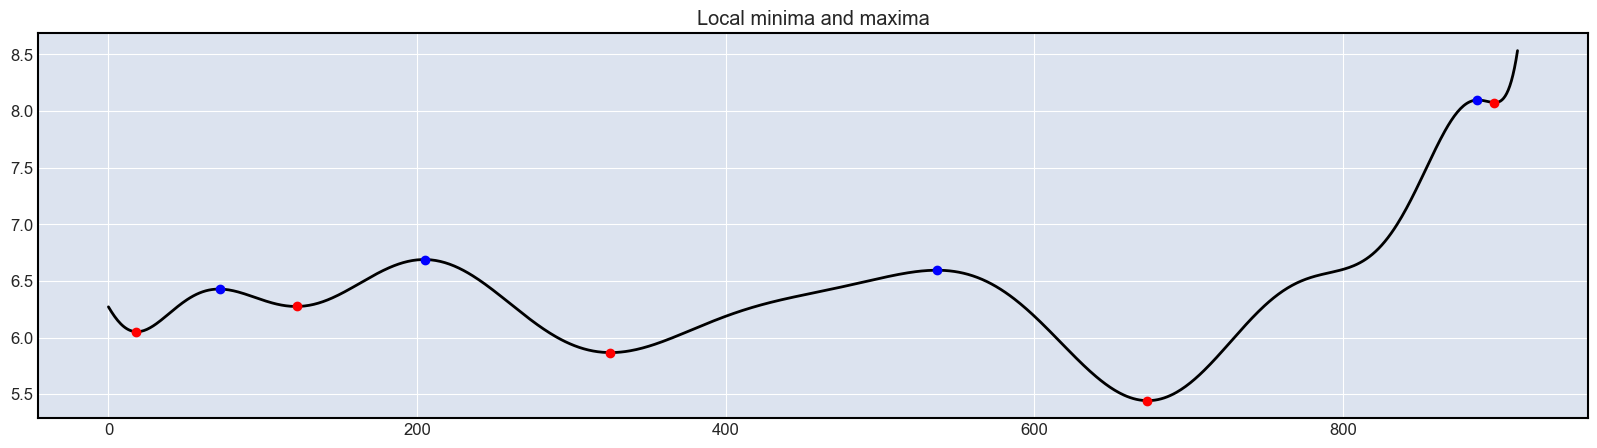

In [19]:
data = y_pol

#detection of local minimums and maximums

min_max = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1          # local min & max
l_min = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1      # local min
l_max = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1      # local max
                                                                    # +1 due to the fact that diff reduces the original index number

# plot
plt.figure(figsize=(20, 5))
plt.plot(x, data, color='black')
plt.plot(x[l_min], data[l_min], "o", label="min", color='red')        # minima
plt.plot(x[l_max], data[l_max], "o", label="max", color='blue')        # maxima
plt.title('Local minima and maxima')
plt.show()


In [20]:
print('corresponding HIGH values for suspected indices: ')
print(ticker_df.High.iloc[l_max])

                                                 #extend the suspected x range:
delta = 5                                        # how many ticks to the left and to the right from local maximum on x axis

dict_i = dict()

for element in l_max:
    l_bound = element - delta                    # lower bound
    u_bound = element + delta                    # upper bound
    x_range = range(l_bound, u_bound + 1)

    y_loc_list = list()
    for x_element in x_range:
        y_loc_list.append(ticker_df.High.iloc[x_element]) 
        
        #print(y_loc_list)
        
    dict_i[element] = y_loc_list
print('DICTIONARY for l_max: ', dict_i)

corresponding HIGH values for suspected indices: 
72     6.72
205    6.65
537    6.53
887    8.22
Name: High, dtype: float64
DICTIONARY for l_max:  {72: [6.480000019073486, 6.460000038146973, 6.460000038146973, 6.53000020980835, 6.659999847412109, 6.71999979019165, 6.650000095367432, 6.639999866485596, 6.670000076293945, 6.71999979019165, 6.769999980926514], 205: [6.760000228881836, 6.75, 6.75, 6.800000190734863, 6.820000171661377, 6.650000095367432, 6.619999885559082, 6.610000133514404, 6.550000190734863, 6.579999923706055, 6.5], 537: [6.679999828338623, 6.699999809265137, 6.570000171661377, 6.53000020980835, 6.539999961853027, 6.53000020980835, 6.550000190734863, 6.539999961853027, 6.53000020980835, 6.590000152587891, 6.619999885559082], 887: [7.840000152587891, 7.829999923706055, 7.860000133514404, 7.920000076293945, 7.989999771118164, 8.220000267028809, 8.479999542236328, 8.550000190734863, 9.039999961853027, 8.829999923706055, 8.630000114440918]}


In [21]:
y_delta = 0.05                              # percentage distance between average highs
threshold = max(ticker_df['High']) * 0.90   # setting threshold lower than the global high

y_dict = dict()
maxi = list()
suspected_tops = list()

for key in dict_i.keys():
    mn = sum(dict_i[key])/len(dict_i[key])
    maxi.append(max(dict_i[key]))
    l_y = mn * (1.0 - y_delta)
    u_y = mn * (1.0 + y_delta)
    y_dict[key] = [l_y, u_y, mn]

print('SCREENING FOR DOUBLE TOP:')    

for key_i in y_dict.keys():    
    for key_j in y_dict.keys():    
        if (key_i != key_j) and (y_dict[key_i][2] > threshold):

            if (y_dict[key_i][2] < y_dict[key_j][1]) and (y_dict[key_i][2] > y_dict[key_j][0]):
                print('---------- ')
                print('---Topping pattern found for x index pair: ', key_i, ',', key_j)
                suspected_tops.append(key_i)
                print('----')
            else:
                print('Not found yet')

SCREENING FOR DOUBLE TOP:
Not found yet
Not found yet
Not found yet


{72: [6.283818160403858, 6.945272703604265, 6.6145454320040615], 205: [6.338227343559264, 7.005409169197083, 6.671818256378174], 537: [6.251000051064925, 6.90900005644018, 6.580000053752553], 887: [7.875500004941766, 8.704500005461952, 8.29000000520186]}


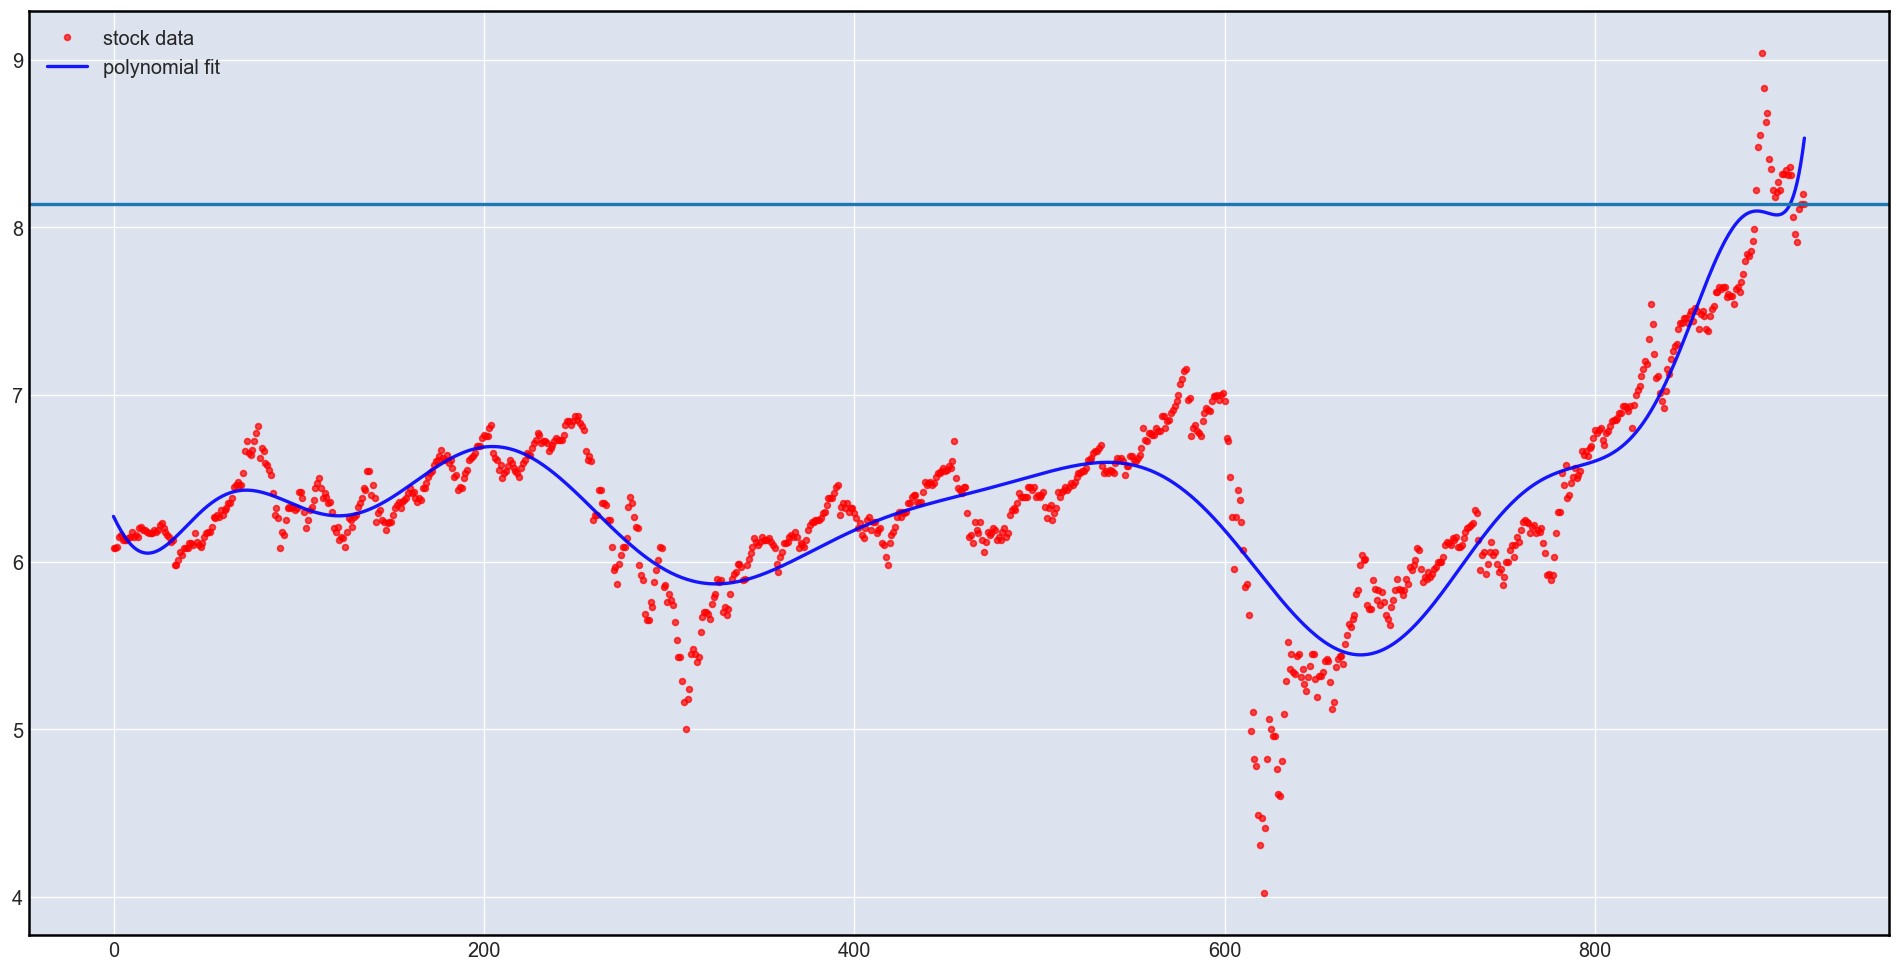

In [23]:
print(y_dict)

#plotting

plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
# plot stock data

plt.plot(x_data, y_data, 'o', markersize=3.5, color='red', alpha=0.7)
# plot polynomial fit

plt.plot(x, y_pol, '-', markersize=1.0, color='blue', alpha=0.9)
plt.legend(['stock data', 'polynomial fit'])

for position in suspected_tops:
    plt.axvline(x=position)

plt.axhline(threshold)    

plt.show()

In [24]:
ticker_df = ticker_df.set_index('Date')

In [25]:
ticker_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-02,6.03,6.08,6.02,6.05,4.096505,1180000
2017-10-03,6.07,6.08,6.02,6.02,4.076193,1467700
2017-10-04,6.04,6.09,6.02,6.07,4.110049,1251300
2017-10-05,6.09,6.15,6.06,6.14,4.157445,1606700
2017-10-06,6.13,6.16,6.08,6.08,4.116819,790200
...,...,...,...,...,...,...
2021-05-13,7.63,7.91,7.63,7.89,7.890000,1153200
2021-05-14,8.04,8.11,8.00,8.10,8.100000,874900
2021-05-17,8.05,8.14,8.02,8.12,8.120000,502900


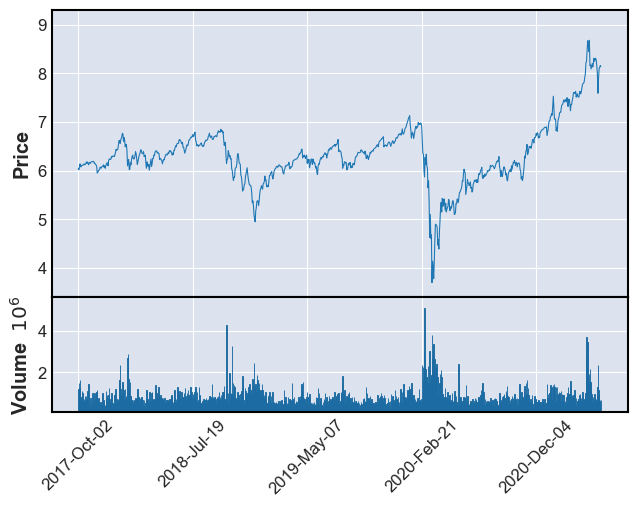

In [26]:
mpf.plot(ticker_df, type='line', volume=True)